                            OLS Regression Results                            
Dep. Variable:                  titer   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     106.4
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           3.39e-39
Time:                        21:42:37   Log-Likelihood:                -1939.8
No. Observations:                 500   AIC:                             3886.
Df Residuals:                     497   BIC:                             3898.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            60.8419      0.87

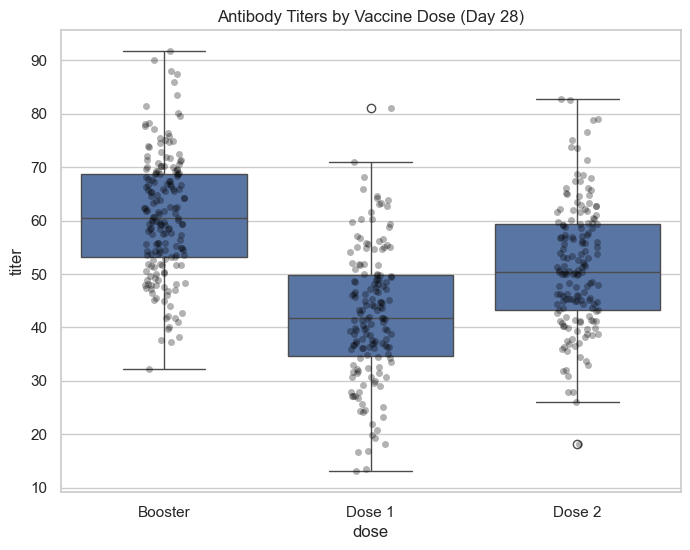

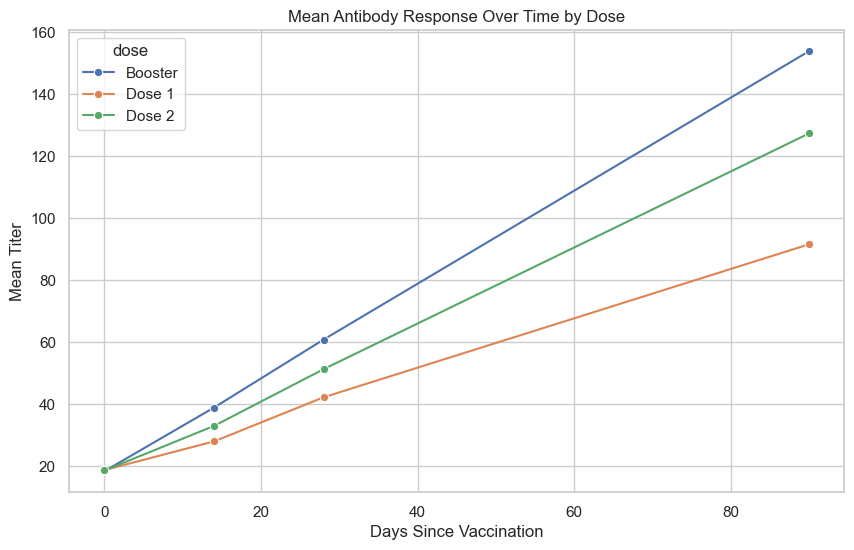

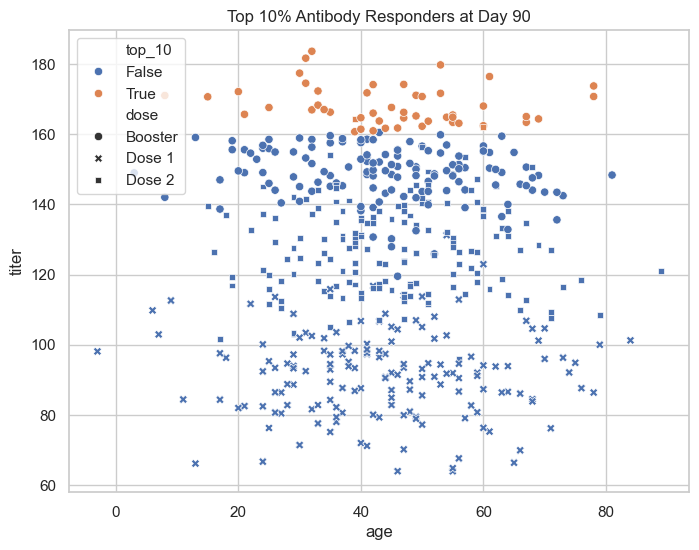

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.formula.api import ols, logit
import statsmodels.api as sm

np.random.seed(123)

# -------------------------
# 1. Simulate Patient Data
# -------------------------
n = 500
patients = pd.DataFrame({
    'patient_id': range(1, n+1),
    'age': np.random.normal(45, 15, n).round(),
    'sex': np.random.choice(['Male', 'Female'], n),
    'bmi': np.random.normal(25, 4, n).round(1),
    'comorbidity': np.random.choice(['None', 'Hypertension', 'Diabetes', 'Both'], 
                                    n, p=[0.5, 0.2, 0.2, 0.1]),
    'dose': np.random.choice(['Dose 1', 'Dose 2', 'Booster'], n)
})

# -------------------------
# 2. Simulate Longitudinal Response
# -------------------------
timepoints = [0, 14, 28, 90]
long_data = patients.loc[patients.index.repeat(len(timepoints))].copy()
long_data['time'] = np.tile(timepoints, n)

base_titer = np.random.normal(20, 5, len(long_data))

# Dose effect
dose_effect = long_data['dose'].map({
    'Dose 1': 0.8,
    'Dose 2': 1.2,
    'Booster': 1.5
})

comorbidity_penalty = long_data['comorbidity'].apply(lambda x: np.random.uniform(2, 5) if x != 'None' else 0)
random_noise = np.random.normal(0, 10, len(long_data))

long_data['titer'] = base_titer + long_data['time'] * dose_effect - comorbidity_penalty + random_noise
long_data['seropositive'] = (long_data['titer'] > 50).astype(int)

# Save dataset
long_data.to_csv("simulated_vaccine_data_python.csv", index=False)

# -------------------------
# 3. Analyze Day 28
# -------------------------
day28 = long_data[long_data['time'] == 28]

# ANOVA
model_anova = ols('titer ~ C(dose)', data=day28).fit()
print(model_anova.summary())
print(sm.stats.anova_lm(model_anova, typ=2))

# Logistic regression
model_logit = logit('seropositive ~ age + sex + bmi + comorbidity + dose', data=day28).fit()
print(model_logit.summary())

# -------------------------
# 4. Visualization
# -------------------------
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
sns.boxplot(x='dose', y='titer', data=day28)
sns.stripplot(x='dose', y='titer', data=day28, jitter=True, color='black', alpha=0.3)
plt.title("Antibody Titers by Vaccine Dose (Day 28)")
plt.show()

# Mean over time
mean_over_time = long_data.groupby(['time', 'dose'])['titer'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=mean_over_time, x='time', y='titer', hue='dose', marker='o')
plt.title("Mean Antibody Response Over Time by Dose")
plt.ylabel("Mean Titer")
plt.xlabel("Days Since Vaccination")
plt.show()

# Highlight top 10% responders at Day 90
day90 = long_data[long_data['time'] == 90].copy()
thresh = day90['titer'].quantile(0.9)
day90['top_10'] = day90['titer'] > thresh

plt.figure(figsize=(8,6))
sns.scatterplot(data=day90, x='age', y='titer', hue='top_10', style='dose')
plt.title("Top 10% Antibody Responders at Day 90")
plt.show()